In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()

# device = torch.device('cpu')
device = None
if use_gpu:
    device = torch.device('cuda:0')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")
    
torch.manual_seed(54)

Using CUDA


In [2]:
# !pip install gputil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()  

 # ****Data preprocessing****

In [3]:
df = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df.describe()

,Follow-up #,Patient ID,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [5]:
df.count()

Image Index                    112120
Finding Labels                 112120
Follow-up #                    112120
Patient ID                     112120
Patient Age                    112120
Patient Gender                 112120
View Position                  112120
OriginalImage[Width            112120
Height]                        112120
OriginalImagePixelSpacing[x    112120
y]                             112120
Unnamed: 11                         0
dtype: int64

In [6]:
df[df['Image Index'].isna()].count()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Unnamed: 11                    0
dtype: int64

In [7]:
df[df['Finding Labels'] == 'No Finding'].count()

Image Index                    60412
Finding Labels                 60412
Follow-up #                    60412
Patient ID                     60412
Patient Age                    60412
Patient Gender                 60412
View Position                  60412
OriginalImage[Width            60412
Height]                        60412
OriginalImagePixelSpacing[x    60412
y]                             60412
Unnamed: 11                        0
dtype: int64

In [8]:
df = df.drop(df[df['Finding Labels'] == 'No Finding'].index)

In [9]:
labels = ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis',
          'hernia', 'infiltration', 'mass', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']

In [10]:
len(labels)

14

In [11]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,074Y,F,PA,2500,2048,0.168,0.168,NaN


In [12]:
df = df.drop(df.columns.difference(['Image Index', 'Finding Labels']), axis=1)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
label_mlb = []
for label in df['Finding Labels'].values:
    splits = label.split('|')
    label_mlb.append(set(splits))

mlb = MultiLabelBinarizer()
label_array = mlb.fit_transform(label_mlb)

In [14]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [15]:
final_df = pd.DataFrame(label_array, columns=mlb.classes_)
final_df.insert(loc=0, column='Image', value=df['Image Index'].values)
final_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0







#  Creating dataset

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [17]:

class ChestXRayDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        
        file = open(self.root)
        images = file.read().splitlines()
        
        ids = []
        
        for idx, path in enumerate(self.df['Image']):
            if path in images:
                ids.append(idx)
        
        self.df = self.df.iloc[ids, :].reset_index(drop=True)
        self.images = self.df['Image'].values
        self.labels = self.df.iloc[:, 1:].values
    
        labels = list(map(lambda x: x.lower(), self.df.columns[1:]))
        self.classes = {v: k for k, v in enumerate(labels)}
        
    def __getitem__(self, item):
        img = Image.open(
            f'/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/{self.images[item]}'
        )
#         img = np.expand_dims(img, axis=-1)
#         img = img.repeat(3, axis=-1)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, torch.tensor(self.labels[item], dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)

In [18]:
basic_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(num_output_channels=3), 
                                          torchvision.transforms.Resize((299, 299)),
                                          torchvision.transforms.ToTensor()
                                          ])

In [19]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [20]:
test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [21]:
len(train_dataset), train_dataset[0]

(36024,
 (tensor([[[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.

# Dealing with class imbalance

In [22]:
len(train_dataset)

36024

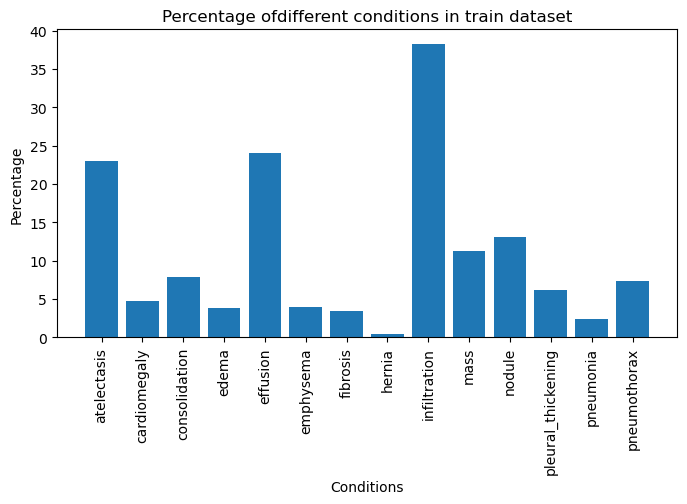

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_29/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


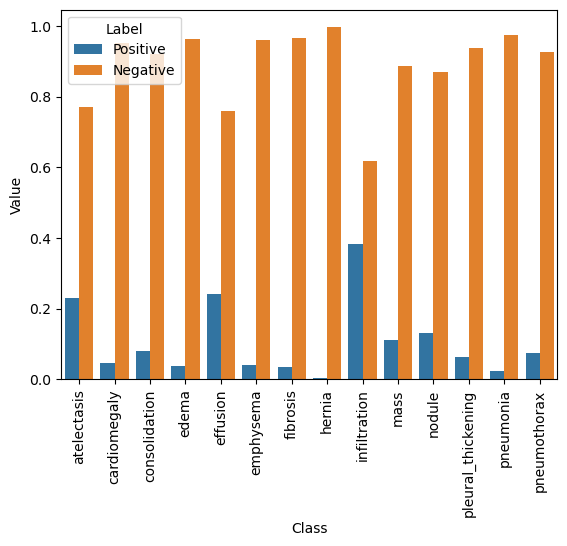

In [24]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_29/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


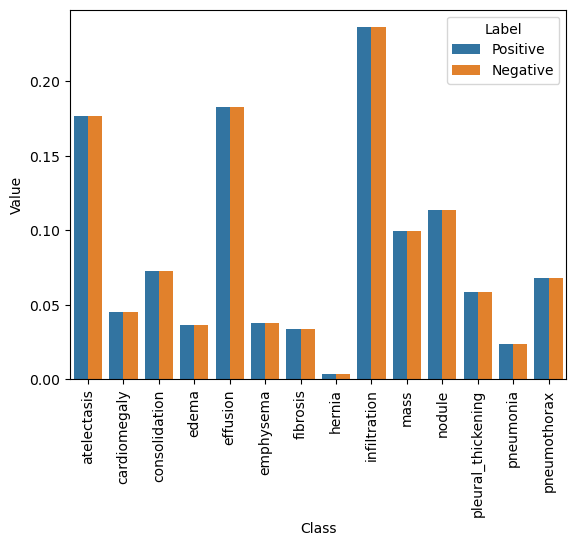

In [25]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [26]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

In [27]:
# cr = WeightedLoss()
# cr(torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], 
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]),
#    torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]))

In [28]:
import random

from torch.utils.data.sampler import Sampler


class MultilabelBalancedRandomSampler(Sampler):
    """
    MultilabelBalancedRandomSampler: Given a multilabel dataset of length n_samples and
    number of classes n_classes, samples from the data with equal probability per class
    effectively oversampling minority classes and undersampling majority classes at the
    same time. Note that using this sampler does not guarantee that the distribution of
    classes in the output samples will be uniform, since the dataset is multilabel and
    sampling is based on a single class. This does however guarantee that all classes
    will have at least batch_size / n_classes samples as batch_size approaches infinity
    """

    def __init__(self, labels, indices=None, class_choice="least_sampled"):
        """
        Parameters:
        -----------
            labels: a multi-hot encoding numpy array of shape (n_samples, n_classes)
            indices: an arbitrary-length 1-dimensional numpy array representing a list
            of indices to sample only from
            class_choice: a string indicating how class will be selected for every
            sample:
                "least_sampled": class with the least number of sampled labels so far
                "random": class is chosen uniformly at random
                "cycle": the sampler cycles through the classes sequentially
        """
        self.labels = labels
        self.indices = indices
        # print(self.labels)
        if self.indices is None:
            self.indices = range(len(labels))

        self.num_classes = self.labels.shape[1]

        # List of lists of example indices per class
        self.class_indices = []
        for class_ in range(self.num_classes):
            lst = np.where(self.labels[:, class_] == 1)[0]
            lst = lst[np.isin(lst, self.indices)]
            self.class_indices.append(lst)

        self.counts = [0] * self.num_classes
        # print(self.counts)
        assert class_choice in ["least_sampled", "random", "cycle"]
        self.class_choice = class_choice
        self.current_class = 0
        # print(self.class_indices)

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count >= len(self.indices):
            raise StopIteration
        self.count += 1
        return self.sample()

    def sample(self):
        class_ = self.get_class()
        class_indices = self.class_indices[class_]
        chosen_index = np.random.choice(class_indices)
        if self.class_choice == "least_sampled":
            for class_, indicator in enumerate(self.labels[chosen_index]):
                if indicator == 1:
                    self.counts[class_] += 1
        return chosen_index

    def get_class(self):
        if self.class_choice == "random":
            class_ = random.randint(0, self.labels.shape[1] - 1)
        elif self.class_choice == "cycle":
            class_ = self.current_class
            self.current_class = (self.current_class + 1) % self.labels.shape[1]
        elif self.class_choice == "least_sampled":
            min_count = self.counts[0]
            min_classes = [0]
            for class_ in range(1, self.num_classes):
                if self.counts[class_] < min_count:
                    min_count = self.counts[class_]
                    min_classes = [class_]
                if self.counts[class_] == min_count:
                    min_classes.append(class_)
            class_ = np.random.choice(min_classes)
        return class_

    def __len__(self):
        return len(self.indices)

# Function that returns balanced accuracies, recall and precision

In [29]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import precision_score, recall_score

def get_classes_accuracy_and_pr(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for i in range(len(outputs[0])):
        bal_acc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
        total_balanced_acc.append(bal_acc)
        
        precision = precision_score(y_true[:, i], y_pred[:, i])
        precision_scores.append(precision)
        
        recall = recall_score(y_true[:, i], y_pred[:, i])
        recall_scores.append(recall)
        
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1)
        
#         cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=mlb.classes)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                       display_labels=mlb.classes)
#         disp.plot()
            
#             bal_acc = balanced_accuracy_score(np_labels[:, i], np_outputs[:, i])
#             batch_balanced_accuracies.append(bal_acc)
#         total_balanced_acc.append(batch_balanced_accuracies)
    
#     mean_acc = np.mean(total_balanced_acc, axis=0)
#     print(len(total_balanced_acc))
#     print(mean_acc)
    return total_balanced_acc, precision_scores, recall_scores, f1_scores

# Training ResNet34

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

BATCH_SIZE = 32
LEARNING_RATE = 1e-6
PIN_MEMORY = False
EPOCHS = 10
THRESHOLD = 0.5

In [31]:
print(DEVICE)

cuda


In [32]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    sampler=MultilabelBalancedRandomSampler(train_dataset.labels),
    drop_last=False,
)

In [33]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [34]:
def train_epoch(loader, model, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    i = 0
    running_loss = 0.
    for images, labels, in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        i += 1
        
    print(f'=> Epoch[{epoch}]: Mean Loss = {np.mean(losses)}')
    torch.save(model.state_dict(), f'./weighted_bce_loss_weights{epoch}.pt')
    
    return np.mean(losses)

In [39]:
resnet = torchvision.models.resnet34(pretrained=True)
resnet.fc = nn.Linear(in_features=512, out_features=14, bias=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 95.2MB/s]


In [42]:
resnet.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
optimizer = optim.Adam(resnet.parameters(), lr=LEARNING_RATE)
loss_fn = WeightedLoss()

In [45]:
with torch.no_grad():
        class_accuracies_pretrained, precisions_pretrained, recalls_pretrained, f1_pretrained = get_classes_accuracy_and_pr(test_loader, resnet)
        print(f'accuracies: {class_accuracies_pretrained}')
        print(f'mean accuracy: {np.mean(class_accuracies_pretrained)}\n')
        
        print(f'precisions: {precisions_pretrained}')
        print(f'mean precision: {np.mean(precisions_pretrained)}\n')
        
        print(f'recalls: {recalls_pretrained}')
        print(f'mean recall: {np.mean(recalls_pretrained)}\n')
        
        print(f'f1: {f1_pretrained}')
        print(f'mean f1: {np.mean(f1_pretrained)}\n')

100%|██████████| 981/981 [04:12<00:00,  3.89it/s]


accuracies: [0.4991945031187282, 0.5119205278872083, 0.49996394837407165, 0.4999382511449725, 0.5224953820355726, 0.5333150384158779, 0.5025975699932839, 0.5009094785556883, 0.5, 0.5399194584094759, 0.5117149070910354, 0.5018012241970888, 0.49905042075542005, 0.5098874586727619]
mean accuracy: 0.5094791549036561

precisions: [0.2043906131718395, 0.07686482393032942, 0.0, 0.058970418747598924, 0.34054054054054056, 0.07617224880382775, 0.06153846153846154, 0.006493506493506494, 0.38816628411119614, 0.14269972451790633, 0.10554670308824646, 0.10317460317460317, 0.030357142857142857, 0.17296643483519805]
mean precision: 0.12627725041502835

recalls: [0.08294930875576037, 0.19061032863849764, 0.0, 0.9956756756756757, 0.24397590361445784, 0.7282708142726441, 0.009195402298850575, 0.011627906976744186, 1.0, 0.30257009345794394, 0.8613003095975232, 0.011373578302712161, 0.9979035639412998, 0.8598271326568959]
mean recall: 0.4496628584420718

f1: [0.11800699300699301, 0.10955207771181869, 0.0, 

In [72]:
losses = []

class_accuracies_by_epochs = []
mean_accuracies_by_epochs = []

class_precs_by_epochs = []
mean_precs_by_epochs = []

class_recs_by_epochs = []
mean_recs_by_epochs = []

class_f1_by_epochs = []
mean_f1_by_epochs = []

In [73]:
for epoch in range(25):
    loss = train_epoch(
        train_loader,
        resnet,
        optimizer,
        loss_fn,
        epoch + 1
    )
    
    with torch.no_grad():
        accs, precs, recs, f1 = get_classes_accuracy_and_pr(test_loader, resnet)
        print(f'epoch {epoch + 1} classes balanced accuracies:')
        print(f'accuracies: {accs}')
        print(f'mean accuracy: {np.mean(accs)}\n')
        
        print(f'precisions: {precs}')
        print(f'mean precision: {np.mean(precs)}\n')
        
        print(f'recalls: {recs}')
        print(f'mean recall: {np.mean(recs)}\n')
        
        print(f'f1: {f1}')
        print(f'mean f1: {np.mean(f1)}\n')
        
        class_accuracies_by_epochs.append(accs)
        mean_accuracies_by_epochs.append(np.mean(accs))
        
        class_precs_by_epochs.append(precs)
        mean_precs_by_epochs.append(np.mean(precs))
        
        class_recs_by_epochs.append(recs)
        mean_recs_by_epochs.append(np.mean(recs))
        
        class_f1_by_epochs.append(f1)
        mean_f1_by_epochs.append(np.mean(f1))
        
        torch.save(class_accuracies_by_epochs, './class_accuracies_by_epochs.pt')
        torch.save(mean_accuracies_by_epochs, './mean_accuracies_by_epochs.pt')
        torch.save(class_precs_by_epochs, './class_precs_by_epochs.pt')
        torch.save(mean_precs_by_epochs, './mean_precs_by_epochs.pt')
        torch.save(class_recs_by_epochs, './class_recs_by_epochs.pt')
        torch.save(mean_recs_by_epochs, './mean_recs_by_epochs.pt')
        torch.save(class_f1_by_epochs, './class_f1_by_epochs.pt')
        torch.save(mean_f1_by_epochs, './mean_f1_by_epochs.pt')
    
        torch.save(resnet.state_dict(), f'./weights_f1_{np.mean(f1)}.pt')
        
    losses.append(loss)

 18%|█▊        | 200/1126 [01:04<05:03,  3.05it/s]

  batch 200 loss: 2.157547666430473


 36%|███▌      | 400/1126 [02:08<03:47,  3.20it/s]

  batch 400 loss: 2.024043851494789


 53%|█████▎    | 600/1126 [03:12<02:46,  3.16it/s]

  batch 600 loss: 1.9459856480360032


 71%|███████   | 800/1126 [04:16<01:45,  3.08it/s]

  batch 800 loss: 1.8829042708873749


 89%|████████▉ | 1000/1126 [05:19<00:40,  3.12it/s]

  batch 1000 loss: 1.8328301370143891


100%|██████████| 1126/1126 [05:58<00:00,  3.14it/s]


=> Epoch[1]: Mean Loss = 1.9487656682041568


100%|██████████| 981/981 [01:29<00:00, 10.93it/s]


epoch 1 classes balanced accuracies:
accuracies: [0.520714487783699, 0.5, 0.5489611470733529, 0.6490665704663943, 0.5680468989300547, 0.5746260823404218, 0.6662901580883767, 0.690713925756731, 0.5375870106302506, 0.5191762028730358, 0.5512013655827636, 0.5660405251076646, 0.49931345751480716, 0.5253441552241153]
mean accuracy: 0.5655058562408334

precisions: [0.2811853893866299, 0.06790359602142311, 0.12776883574768147, 0.08472222222222223, 0.3336686787391013, 0.0984102952308857, 0.06512493354598618, 0.009106052193225985, 0.49784567175871525, 0.18048780487804877, 0.12063832321067047, 0.08569074430101621, 0.03037263910158244, 0.17737824619411724]
mean precision: 0.15430738803795044

recalls: [0.12534562211981568, 1.0, 0.9184573002754821, 0.9232432432432433, 0.8562822719449226, 0.4757548032936871, 0.5632183908045977, 0.9534883720930233, 0.2087713534822602, 0.08644859813084112, 0.6272445820433437, 0.8188976377952756, 0.9979035639412998, 0.9676813228109733]
mean recall: 0.6801955044270546


 18%|█▊        | 200/1126 [01:02<04:50,  3.19it/s]

  batch 200 loss: 1.7477896600961684


 36%|███▌      | 400/1126 [02:04<03:48,  3.18it/s]

  batch 400 loss: 1.7260369342565536


 53%|█████▎    | 600/1126 [03:06<02:37,  3.33it/s]

  batch 600 loss: 1.6783166581392288


 71%|███████   | 800/1126 [04:08<01:38,  3.31it/s]

  batch 800 loss: 1.6614966523647308


 89%|████████▉ | 1000/1126 [05:10<00:38,  3.30it/s]

  batch 1000 loss: 1.6346402668952942


100%|██████████| 1126/1126 [05:49<00:00,  3.22it/s]


=> Epoch[2]: Mean Loss = 1.68220356694335


100%|██████████| 981/981 [01:30<00:00, 10.87it/s]


epoch 2 classes balanced accuracies:
accuracies: [0.5405594838591031, 0.5001026061974143, 0.5422873058351791, 0.6459626833283585, 0.606456751772793, 0.5921718654601844, 0.6810316561176426, 0.6653379831045722, 0.5627234149248564, 0.5724691204839586, 0.5735177377661227, 0.5578453069887824, 0.5000328795949234, 0.5391793168638159]
mean accuracy: 0.577119865164122

precisions: [0.33725976441413513, 0.06791658695236273, 0.12577777777777777, 0.08338937457969066, 0.37414813987263995, 0.08627555083620919, 0.05480905233380481, 0.008317466680028059, 0.5076726342710998, 0.16071845113132727, 0.13834911144328185, 0.0823775573465592, 0.03041509915194797, 0.18176733780760626]
mean precision: 0.1599424217570336

recalls: [0.16712749615975422, 1.0, 0.9355371900826446, 0.9383783783783783, 0.7205249569707401, 0.8920402561756633, 0.7126436781609196, 0.9651162790697675, 0.32605124835742444, 0.4024532710280374, 0.5157894736842106, 0.9300087489063867, 1.0, 0.977076287110109]
mean recall: 0.7487676617202883

f

 18%|█▊        | 200/1126 [01:02<04:44,  3.26it/s]

  batch 200 loss: 1.6098749792575837


 36%|███▌      | 400/1126 [02:07<03:54,  3.10it/s]

  batch 400 loss: 1.5872014272212982


 53%|█████▎    | 600/1126 [03:11<02:47,  3.15it/s]

  batch 600 loss: 1.5717760300636292


 71%|███████   | 800/1126 [04:12<01:39,  3.28it/s]

  batch 800 loss: 1.5484625470638276


 89%|████████▉ | 1000/1126 [05:15<00:39,  3.22it/s]

  batch 1000 loss: 1.5396182626485824


100%|██████████| 1126/1126 [05:54<00:00,  3.18it/s]


=> Epoch[3]: Mean Loss = 1.5659976104013027


100%|██████████| 981/981 [01:30<00:00, 10.86it/s]


epoch 3 classes balanced accuracies:
accuracies: [0.5610859914730415, 0.5076270606744647, 0.5448767660082626, 0.6402103343264669, 0.6215711887055289, 0.5690980095702505, 0.6824230418727288, 0.6289588408770355, 0.5750257170229164, 0.5766566510858834, 0.5895999746494884, 0.566350175384256, 0.5000328795949234, 0.5715614062744424]
mean accuracy: 0.5810770026799777

precisions: [0.34050632911392403, 0.06888299592523123, 0.12631424159988236, 0.08140389562660787, 0.3949652777777778, 0.08037411603680328, 0.05128987940772401, 0.007375010719492325, 0.519091122042633, 0.14746845813534326, 0.1524390243902439, 0.08413384566122319, 0.03041509915194797, 0.19319788643298355]
mean precision: 0.16270408443012987

recalls: [0.24792626728110598, 1.0, 0.946556473829201, 0.9578378378378378, 0.6852409638554217, 0.9670631290027447, 0.7724137931034483, 1.0, 0.3639947437582129, 0.5257009345794392, 0.4953560371517028, 0.9195100612423447, 1.0, 0.9755730928222472]
mean recall: 0.7755123810331218

f1: [0.2869333333

 18%|█▊        | 200/1126 [01:01<04:40,  3.31it/s]

  batch 200 loss: 1.5184408497810364


 36%|███▌      | 400/1126 [02:02<03:36,  3.35it/s]

  batch 400 loss: 1.4985720014572144


 53%|█████▎    | 600/1126 [03:03<02:40,  3.29it/s]

  batch 600 loss: 1.4873278510570527


 71%|███████   | 800/1126 [04:05<01:37,  3.35it/s]

  batch 800 loss: 1.4852827101945878


 89%|████████▉ | 1000/1126 [05:06<00:39,  3.17it/s]

  batch 1000 loss: 1.4612139511108397


100%|██████████| 1126/1126 [05:44<00:00,  3.27it/s]


=> Epoch[4]: Mean Loss = 1.4868494424684433


100%|██████████| 981/981 [01:29<00:00, 10.93it/s]


epoch 4 classes balanced accuracies:
accuracies: [0.5635399298429827, 0.5345379204565928, 0.5476221718095354, 0.6360712565672252, 0.6330827634048856, 0.5692057976307068, 0.6747045029521439, 0.5787921528401077, 0.5747229463218084, 0.5802636648463817, 0.5987448856113181, 0.5755828257180664, 0.5000328795949234, 0.5997852987702531]
mean accuracy: 0.5833349283119238

precisions: [0.3495019488956258, 0.07259056732740943, 0.1270689527202553, 0.08036843055806393, 0.42589285714285713, 0.0802892219627928, 0.04660367722165475, 0.006502343868138515, 0.5224312590448625, 0.14193893947509373, 0.15183603757472247, 0.08611570247933885, 0.03041509915194797, 0.20470438652256834]
mean precision: 0.16616138742466652

recalls: [0.24792626728110598, 0.9971830985915493, 0.9432506887052342, 0.9621621621621622, 0.6157487091222031, 0.9752973467520586, 0.8390804597701149, 1.0, 0.35578186596583444, 0.6191588785046729, 0.5504643962848297, 0.9116360454943132, 1.0, 0.9680571213829388]
mean recall: 0.7846962171440728


 18%|█▊        | 200/1126 [01:01<04:43,  3.27it/s]

  batch 200 loss: 1.4413367640972137


 36%|███▌      | 400/1126 [02:03<03:58,  3.04it/s]

  batch 400 loss: 1.4421533608436585


 53%|█████▎    | 600/1126 [03:04<02:39,  3.29it/s]

  batch 600 loss: 1.4367283862829208


 71%|███████   | 800/1126 [04:05<01:38,  3.29it/s]

  batch 800 loss: 1.4201363027095795


 89%|████████▉ | 1000/1126 [05:06<00:37,  3.33it/s]

  batch 1000 loss: 1.4027053678035737


100%|██████████| 1126/1126 [05:45<00:00,  3.26it/s]


=> Epoch[5]: Mean Loss = 1.4259512125916423


100%|██████████| 981/981 [01:29<00:00, 10.99it/s]


epoch 5 classes balanced accuracies:
accuracies: [0.5815321533221138, 0.5804685008608323, 0.5484725134657292, 0.6336953173784937, 0.6427387695035306, 0.5639764777482867, 0.6708007986956748, 0.5572829849980767, 0.5770570263343411, 0.588641234404724, 0.602229282613532, 0.5855719577243891, 0.500164397974617, 0.6167255383134912]
mean accuracy: 0.5892397823812737

precisions: [0.33972344437460716, 0.08017201658731378, 0.12736660929432014, 0.07976775346136668, 0.42697257974258535, 0.07933565655816713, 0.0459886291850916, 0.00618838598258617, 0.5266586248492159, 0.15074603907091216, 0.16086786551993745, 0.08839637172685265, 0.030422858600676065, 0.21258008153756552]
mean precision: 0.16822763689222842

recalls: [0.33210445468509986, 0.9802816901408451, 0.9377410468319559, 0.9654054054054054, 0.6566265060240963, 0.9789569990850869, 0.8367816091954023, 1.0, 0.3585742444152431, 0.572429906542056, 0.5095975232198142, 0.9037620297462817, 1.0, 0.9601653513716648]
mean recall: 0.7851733404759251

f1

 18%|█▊        | 200/1126 [01:01<04:43,  3.27it/s]

  batch 200 loss: 1.393490542769432


 36%|███▌      | 400/1126 [02:03<03:37,  3.34it/s]

  batch 400 loss: 1.3860899132490159


 53%|█████▎    | 600/1126 [03:04<02:40,  3.28it/s]

  batch 600 loss: 1.3766669166088104


 71%|███████   | 800/1126 [04:06<01:37,  3.33it/s]

  batch 800 loss: 1.3593027067184449


 89%|████████▉ | 1000/1126 [05:07<00:38,  3.27it/s]

  batch 1000 loss: 1.355527656674385


100%|██████████| 1126/1126 [05:45<00:00,  3.25it/s]


=> Epoch[6]: Mean Loss = 1.371439017686285


100%|██████████| 981/981 [01:29<00:00, 10.98it/s]


epoch 6 classes balanced accuracies:
accuracies: [0.5808260226844235, 0.6089715390640581, 0.5466005700328159, 0.6398610467639535, 0.6500181848920041, 0.5926432422748912, 0.6617435626078363, 0.5305167329144762, 0.5824736914033936, 0.5910121310712212, 0.6097963002776894, 0.5841639559857988, 0.5002301571644637, 0.648443249437882]
mean accuracy: 0.5948071704696362

precisions: [0.34402618657937806, 0.08600351376223542, 0.12689521248786317, 0.08108598928539, 0.4289768887687525, 0.0847011952191235, 0.04346826126954922, 0.005837632364919902, 0.5253404777852199, 0.1480858224652924, 0.16444444444444445, 0.08796413769770786, 0.03042673980991261, 0.22889390519187358]
mean precision: 0.17043931479511878

recalls: [0.3228878648233487, 0.9652582159624413, 0.9360881542699725, 0.9654054054054054, 0.6828743545611016, 0.9725526075022873, 0.8689655172413793, 1.0, 0.3864980289093298, 0.616822429906542, 0.5269349845201239, 0.9098862642169728, 1.0, 0.9526493799323562]
mean recall: 0.7933445148036614

f1: [0

 18%|█▊        | 200/1126 [01:00<04:39,  3.31it/s]

  batch 200 loss: 1.3331993329524994


 36%|███▌      | 400/1126 [02:01<03:38,  3.33it/s]

  batch 400 loss: 1.3350832980871201


 53%|█████▎    | 600/1126 [03:02<02:39,  3.29it/s]

  batch 600 loss: 1.3166910886764527


 71%|███████   | 800/1126 [04:03<01:38,  3.32it/s]

  batch 800 loss: 1.3063198655843735


 89%|████████▉ | 1000/1126 [05:05<00:42,  2.97it/s]

  batch 1000 loss: 1.3122436475753785


100%|██████████| 1126/1126 [05:43<00:00,  3.28it/s]


=> Epoch[7]: Mean Loss = 1.318061924001887


100%|██████████| 981/981 [01:29<00:00, 11.00it/s]


epoch 7 classes balanced accuracies:
accuracies: [0.5898751730103485, 0.6364984214060614, 0.5460829163560565, 0.6344361205164782, 0.6528434324467133, 0.6079216511851702, 0.6698207457357295, 0.5290742402872163, 0.5851996547510214, 0.5982433826264011, 0.6107779284186936, 0.5959052157886082, 0.5006904714933912, 0.6635614589087505]
mean accuracy: 0.6014950580664743

precisions: [0.3402002861230329, 0.09304267161410018, 0.12675216224276767, 0.07982893799002139, 0.4310739792480798, 0.08801670146137787, 0.04565298740177123, 0.005819855180347838, 0.5239623448866068, 0.15709486482162854, 0.17450412302206375, 0.09133000453926464, 0.030453936027580925, 0.2390552995391705]
mean precision: 0.1733420110069867

recalls: [0.365284178187404, 0.9417840375586854, 0.9366391184573003, 0.9686486486486486, 0.6882530120481928, 0.9643183897529735, 0.8413793103448276, 1.0, 0.40226675427069647, 0.5735981308411215, 0.4848297213622291, 0.8801399825021873, 1.0, 0.9357384441939121]
mean recall: 0.78449140915487

f1:

 18%|█▊        | 200/1126 [01:00<04:41,  3.29it/s]

  batch 200 loss: 1.2969316601753236


 36%|███▌      | 400/1126 [02:02<03:36,  3.35it/s]

  batch 400 loss: 1.2778198873996736


 53%|█████▎    | 600/1126 [03:03<02:39,  3.29it/s]

  batch 600 loss: 1.2856079566478729


 71%|███████   | 800/1126 [04:04<01:40,  3.26it/s]

  batch 800 loss: 1.2673158705234528


 89%|████████▉ | 1000/1126 [05:05<00:41,  3.04it/s]

  batch 1000 loss: 1.2569645673036576


100%|██████████| 1126/1126 [05:44<00:00,  3.26it/s]


=> Epoch[8]: Mean Loss = 1.2741075969081153


100%|██████████| 981/981 [01:32<00:00, 10.66it/s]


epoch 8 classes balanced accuracies:
accuracies: [0.5974207044399285, 0.6620012158593533, 0.5520580711247929, 0.6428392753482529, 0.6554749391601512, 0.6203711408159148, 0.6714127099346254, 0.5230478266444416, 0.5847650124148313, 0.6003038286185187, 0.617399561251303, 0.5968395816625666, 0.5009535082527783, 0.6709632883491795]
mean accuracy: 0.6068464759911885

precisions: [0.3427495291902072, 0.10133028476408232, 0.12847116264876413, 0.08166803540469021, 0.44308180637714617, 0.09082275748942416, 0.04514347460679553, 0.005746742398930839, 0.5195588847274241, 0.15534420289855072, 0.16882865440464667, 0.09191244667037655, 0.030469498562759503, 0.24347826086956523]
mean precision: 0.17490041007238313

recalls: [0.3913978494623656, 0.9154929577464789, 0.9278236914600551, 0.9675675675675676, 0.6607142857142857, 0.9624885635864593, 0.864367816091954, 1.0, 0.4101511169513798, 0.6010514018691588, 0.5399380804953561, 0.8670166229221348, 1.0, 0.936490041337843]
mean recall: 0.7888928568003599

f

 18%|█▊        | 200/1126 [01:01<04:45,  3.24it/s]

  batch 200 loss: 1.2519866800308228


 36%|███▌      | 400/1126 [02:02<03:46,  3.21it/s]

  batch 400 loss: 1.2257072061300278


 53%|█████▎    | 600/1126 [03:03<03:05,  2.84it/s]

  batch 600 loss: 1.229038909673691


 71%|███████   | 800/1126 [04:04<01:39,  3.29it/s]

  batch 800 loss: 1.2259762799739837


 89%|████████▉ | 1000/1126 [05:06<00:37,  3.33it/s]

  batch 1000 loss: 1.2007228326797486


100%|██████████| 1126/1126 [05:45<00:00,  3.26it/s]


=> Epoch[9]: Mean Loss = 1.2233500214918893


100%|██████████| 981/981 [01:31<00:00, 10.75it/s]


epoch 9 classes balanced accuracies:
accuracies: [0.5872816769759144, 0.6632293108813632, 0.5539307892207426, 0.6506988864330148, 0.6579649125160092, 0.6485036051312635, 0.6695729058547649, 0.5331773304269778, 0.5753681998467386, 0.5980078481395368, 0.6191908433600255, 0.6086571033376347, 0.5006615209066662, 0.6851460701606671]
mean accuracy: 0.6108136430850942

precisions: [0.3448170731707317, 0.10150336962156557, 0.1290795463313016, 0.08343432460147292, 0.4420473773265651, 0.0986388036809816, 0.044989775051124746, 0.005870707898150044, 0.5152818655195834, 0.15590304925723222, 0.16935793925413303, 0.09565733504797705, 0.03045230631437528, 0.2552012545739676]
mean precision: 0.17658819483208302

recalls: [0.3474654377880184, 0.9192488262910798, 0.9217630853994491, 0.9675675675675676, 0.6744836488812392, 0.9414455626715462, 0.8597701149425288, 1.0, 0.37385019710906703, 0.5823598130841121, 0.5455108359133127, 0.8460192475940508, 0.9979035639412998, 0.9173243141676062]
mean recall: 0.7781

 18%|█▊        | 200/1126 [01:01<04:38,  3.32it/s]

  batch 200 loss: 1.1938114154338837


 36%|███▌      | 400/1126 [02:03<03:39,  3.31it/s]

  batch 400 loss: 1.192687999010086


 53%|█████▎    | 600/1126 [03:04<02:39,  3.30it/s]

  batch 600 loss: 1.174610567688942


 71%|███████   | 800/1126 [04:06<01:40,  3.25it/s]

  batch 800 loss: 1.176077223420143


 89%|████████▉ | 1000/1126 [05:08<00:38,  3.26it/s]

  batch 1000 loss: 1.1655152216553688


100%|██████████| 1126/1126 [05:47<00:00,  3.24it/s]


=> Epoch[10]: Mean Loss = 1.1787577524490085


100%|██████████| 981/981 [01:32<00:00, 10.59it/s]


epoch 10 classes balanced accuracies:
accuracies: [0.5867438757210077, 0.6871059175354473, 0.5560613509289104, 0.6554492632072414, 0.6557837392130528, 0.6478541804994156, 0.6788103685713704, 0.5400371842543916, 0.5753548483572053, 0.593971069642623, 0.6175726357072078, 0.6122295884873272, 0.5014216805981025, 0.6949550102191068]
mean accuracy: 0.614525050924458

precisions: [0.3475132937128558, 0.11127977580569827, 0.1298314386515092, 0.0847457627118644, 0.4512158054711246, 0.09834190966266437, 0.04700038211692778, 0.005957741600277104, 0.5126385809312639, 0.15555195856264162, 0.1766104626026805, 0.09711607051869968, 0.030497592295345103, 0.26303240489866697]
mean precision: 0.17938094139587277

recalls: [0.34132104454685097, 0.8948356807511737, 0.912396694214876, 0.9621621621621622, 0.6387693631669535, 0.9441903019213175, 0.8482758620689655, 1.0, 0.3797634691195795, 0.5613317757009346, 0.5058823529411764, 0.8337707786526685, 0.9958071278825996, 0.9120631341600902]
mean recall: 0.766469

 18%|█▊        | 200/1126 [01:01<04:43,  3.27it/s]

  batch 200 loss: 1.1505474525690078


 36%|███▌      | 400/1126 [02:01<03:35,  3.37it/s]

  batch 400 loss: 1.1465821042656898


 53%|█████▎    | 600/1126 [03:01<02:37,  3.34it/s]

  batch 600 loss: 1.1402931654453277


 71%|███████   | 800/1126 [04:00<01:37,  3.35it/s]

  batch 800 loss: 1.1374116894602775


 89%|████████▉ | 1000/1126 [05:00<00:37,  3.37it/s]

  batch 1000 loss: 1.1256835174560547


100%|██████████| 1126/1126 [05:37<00:00,  3.33it/s]


=> Epoch[11]: Mean Loss = 1.1368798479093751


100%|██████████| 981/981 [01:30<00:00, 10.86it/s]


epoch 11 classes balanced accuracies:
accuracies: [0.590247907654649, 0.6963842154094276, 0.5631752603612671, 0.6625785823766717, 0.6564680120575503, 0.6693300580143057, 0.6710520305458131, 0.5571227080394923, 0.57991653881189, 0.5977493204031561, 0.6186913370568363, 0.6101206995298478, 0.5016518377625663, 0.7011949026789045]
mean accuracy: 0.619691672193027

precisions: [0.34668260609683205, 0.11594381468703795, 0.1321657342090327, 0.08693934005137324, 0.4662240663900415, 0.10552606931002186, 0.04508393285371703, 0.006186160264710114, 0.5084882780921585, 0.1570992120919762, 0.17293997965412003, 0.09671160130718955, 0.03051130524152107, 0.2724959518852649]
mean precision: 0.18164271800964263

recalls: [0.3563748079877112, 0.8835680751173709, 0.8980716253443526, 0.9513513513513514, 0.6043459552495697, 0.9277218664226898, 0.864367816091954, 1.0, 0.4132720105124836, 0.570677570093458, 0.5263157894736842, 0.8285214348206474, 0.9958071278825996, 0.8853814355505449]
mean recall: 0.7646983475

 18%|█▊        | 200/1126 [01:01<04:39,  3.31it/s]

  batch 200 loss: 1.1213384032249452


 36%|███▌      | 400/1126 [02:02<03:40,  3.29it/s]

  batch 400 loss: 1.0930863243341447


 53%|█████▎    | 600/1126 [03:03<02:37,  3.33it/s]

  batch 600 loss: 1.0902887663245202


 71%|███████   | 800/1126 [04:04<01:37,  3.33it/s]

  batch 800 loss: 1.0826280251145364


 89%|████████▉ | 1000/1126 [05:06<00:39,  3.19it/s]

  batch 1000 loss: 1.0779557651281357


100%|██████████| 1126/1126 [05:44<00:00,  3.27it/s]


=> Epoch[12]: Mean Loss = 1.091205377297122


100%|██████████| 981/981 [01:30<00:00, 10.88it/s]


epoch 12 classes balanced accuracies:
accuracies: [0.5828849802361283, 0.7028857872592968, 0.561184972252166, 0.6630513676492402, 0.6567175084639287, 0.6805049961553084, 0.6783149149407197, 0.5862290037184255, 0.5665083225654141, 0.6010220541215944, 0.6195874072214189, 0.6090317341444348, 0.5043518935544827, 0.7038842301466289]
mean accuracy: 0.6225827980306563

precisions: [0.35011670556852287, 0.11910512266429389, 0.13163223977318753, 0.08701234567901235, 0.45080608708753955, 0.11010790574763268, 0.04708750320759559, 0.0066184392796675385, 0.5111717974180735, 0.16115423557205535, 0.17753389283408652, 0.09620432061376943, 0.030673655600854204, 0.2740757909375362]
mean precision: 0.18237857442741626

recalls: [0.3225806451612903, 0.8798122065727699, 0.8953168044077136, 0.9524324324324325, 0.6437177280550774, 0.9149130832570905, 0.8436781609195402, 1.0, 0.3382063074901445, 0.5578271028037384, 0.5108359133126935, 0.8337707786526685, 0.9937106918238994, 0.8887636226982337]
mean recall: 0.

 18%|█▊        | 200/1126 [01:01<04:38,  3.32it/s]

  batch 200 loss: 1.0618195402622224


 36%|███▌      | 400/1126 [02:02<03:41,  3.27it/s]

  batch 400 loss: 1.058012924194336


 53%|█████▎    | 600/1126 [03:04<02:41,  3.25it/s]

  batch 600 loss: 1.0457369807362555


 71%|███████   | 800/1126 [04:05<01:55,  2.83it/s]

  batch 800 loss: 1.0472655040025711


 89%|████████▉ | 1000/1126 [05:06<00:38,  3.30it/s]

  batch 1000 loss: 1.0371757501363754


100%|██████████| 1126/1126 [05:45<00:00,  3.26it/s]


=> Epoch[13]: Mean Loss = 1.0476388755530701


100%|██████████| 981/981 [01:31<00:00, 10.73it/s]


epoch 13 classes balanced accuracies:
accuracies: [0.5858882878714231, 0.716134896801288, 0.567536315309308, 0.6694986293292412, 0.6574168704019204, 0.6858970013913376, 0.6833935973189875, 0.5991793819720477, 0.5647138823721447, 0.6012010670205565, 0.6178967129496882, 0.6138744081582334, 0.5065298048358233, 0.7073651066221318]
mean accuracy: 0.6268947115967237

precisions: [0.3416036308623298, 0.12849477548715052, 0.1337945981993998, 0.08903830480847595, 0.4597682907475004, 0.11198120595144871, 0.0482357605391833, 0.006830818109610802, 0.5092964824120603, 0.16391697711548697, 0.18412924685198384, 0.097696421225833, 0.030807388551661118, 0.28034786810001205]
mean precision: 0.18471012635443834

recalls: [0.3468509984639017, 0.8544600938967136, 0.8842975206611571, 0.9448648648648649, 0.6232788296041308, 0.9158279963403476, 0.8390804597701149, 1.0, 0.3329500657030223, 0.5397196261682243, 0.47987616099071206, 0.8311461067366579, 0.989517819706499, 0.872228485531755]
mean recall: 0.74672135

 18%|█▊        | 200/1126 [01:01<05:18,  2.91it/s]

  batch 200 loss: 1.0324222239851952


 36%|███▌      | 400/1126 [02:01<03:37,  3.34it/s]

  batch 400 loss: 1.0251856219768525


 53%|█████▎    | 600/1126 [03:02<02:39,  3.29it/s]

  batch 600 loss: 1.0105080339312553


 71%|███████   | 800/1126 [04:04<01:38,  3.32it/s]

  batch 800 loss: 1.007767432630062


 89%|████████▉ | 1000/1126 [05:05<00:38,  3.29it/s]

  batch 1000 loss: 0.9928094771504402


100%|██████████| 1126/1126 [05:44<00:00,  3.27it/s]


=> Epoch[14]: Mean Loss = 1.0112291074773134


100%|██████████| 981/981 [01:32<00:00, 10.59it/s]


epoch 14 classes balanced accuracies:
accuracies: [0.584794703037678, 0.721707232243588, 0.5707021843709945, 0.6773996260641697, 0.6537598511895665, 0.689846439949729, 0.6791364498746102, 0.6221310424413387, 0.5670538164993189, 0.6047171947366027, 0.6166404762727354, 0.6177467965049861, 0.5100150418977027, 0.7052814199766764]
mean accuracy: 0.6300665910756926

precisions: [0.3407429963459196, 0.13570548367221194, 0.13504768392370572, 0.09149294588334386, 0.4582327378078223, 0.11380255941499086, 0.04714926329276105, 0.007242715176014822, 0.505152224824356, 0.1628297765081499, 0.1787797218483625, 0.0993321318774515, 0.031022017745645745, 0.2776059019514517]
mean precision: 0.18458129716229912

recalls: [0.343778801843318, 0.8272300469483568, 0.8738292011019284, 0.9394594594594594, 0.6125215146299484, 0.9112534309240622, 0.8459770114942529, 1.0, 0.3543035479632063, 0.5660046728971962, 0.4934984520123839, 0.8197725284339458, 0.989517819706499, 0.8767380683953401]
mean recall: 0.74670603970

 18%|█▊        | 200/1126 [01:01<04:47,  3.22it/s]

  batch 200 loss: 0.9819283959269524


 36%|███▌      | 400/1126 [02:02<03:38,  3.32it/s]

  batch 400 loss: 0.9703055366873741


 53%|█████▎    | 600/1126 [03:03<02:43,  3.21it/s]

  batch 600 loss: 0.9565033593773842


 71%|███████   | 800/1126 [04:04<01:39,  3.27it/s]

  batch 800 loss: 0.9687479618191719


 89%|████████▉ | 1000/1126 [05:06<00:38,  3.29it/s]

  batch 1000 loss: 0.9571542671322822


100%|██████████| 1126/1126 [05:44<00:00,  3.27it/s]


=> Epoch[15]: Mean Loss = 0.9656411451725935


100%|██████████| 981/981 [01:30<00:00, 10.85it/s]


epoch 15 classes balanced accuracies:
accuracies: [0.5827023762250689, 0.7219806560823316, 0.5722476967182294, 0.6728510134906232, 0.6518079775218515, 0.7036756355654952, 0.6850294309858646, 0.6496986793178613, 0.5601559577222003, 0.6075282240047519, 0.6179041508601899, 0.615187285620657, 0.5113420127192335, 0.7127679577568123]
mean accuracy: 0.633205646756512

precisions: [0.3441101152368758, 0.13421606981643094, 0.1356602475928473, 0.08989110334908568, 0.46102819237147596, 0.12171837708830549, 0.048757555406312963, 0.007808244053023425, 0.49696528283563973, 0.16872502724300764, 0.17937821516439276, 0.09931766489764973, 0.031109047492703636, 0.28989769820971867]
mean precision: 0.18632734576839072

recalls: [0.3302611367127496, 0.8375586854460094, 0.8694214876033057, 0.9459459459459459, 0.5981067125645438, 0.8865507776761208, 0.8344827586206897, 1.0, 0.3362352168199737, 0.5426401869158879, 0.496594427244582, 0.8022747156605424, 0.9832285115303984, 0.851935362645622]
mean recall: 0.736

 18%|█▊        | 200/1126 [01:01<04:37,  3.34it/s]

  batch 200 loss: 0.935969355404377


 36%|███▌      | 400/1126 [02:02<03:40,  3.29it/s]

  batch 400 loss: 0.9312999403476715


 53%|█████▎    | 600/1126 [03:03<02:36,  3.35it/s]

  batch 600 loss: 0.9287459343671799


 71%|███████   | 800/1126 [04:04<01:40,  3.23it/s]

  batch 800 loss: 0.9200382536649704


 89%|████████▉ | 1000/1126 [05:05<00:38,  3.31it/s]

  batch 1000 loss: 0.9121392500400544


100%|██████████| 1126/1126 [05:43<00:00,  3.27it/s]


=> Epoch[16]: Mean Loss = 0.924234010080673


100%|██████████| 981/981 [01:31<00:00, 10.70it/s]


epoch 16 classes balanced accuracies:
accuracies: [0.5797142330650074, 0.722518736469711, 0.5721912654954954, 0.6728216406663456, 0.6518839688480011, 0.709413985974259, 0.6809109020150559, 0.6563624734238439, 0.5594169698938289, 0.609347533518305, 0.6171024849442828, 0.6212968092213148, 0.5183124868429922, 0.7185791576277198]
mean accuracy: 0.6349909034290115

precisions: [0.34136023429873086, 0.13604812586765386, 0.1357013535649625, 0.09004543577034284, 0.4689834926151173, 0.1256737215722361, 0.04906607192640089, 0.008090457159567209, 0.5, 0.17040029379361, 0.1793025871766029, 0.10233784093513637, 0.031552744886975244, 0.3017088174982912]
mean precision: 0.18859079836183051

recalls: [0.32227342549923194, 0.828169014084507, 0.8672176308539945, 0.9427027027027027, 0.5806798623063684, 0.8746569075937786, 0.8091954022988506, 0.9651162790697675, 0.325065703022339, 0.5420560747663551, 0.4934984520123839, 0.7812773403324584, 0.9832285115303984, 0.8293874483276964]
mean recall: 0.72460891102

 18%|█▊        | 200/1126 [01:01<04:38,  3.33it/s]

  batch 200 loss: 0.9017435619235039


 36%|███▌      | 400/1126 [02:02<03:40,  3.29it/s]

  batch 400 loss: 0.9042312848567963


 53%|█████▎    | 600/1126 [03:03<02:37,  3.33it/s]

  batch 600 loss: 0.8906226199865341


 71%|███████   | 800/1126 [04:04<01:37,  3.33it/s]

  batch 800 loss: 0.8912974229454994


 89%|████████▉ | 1000/1126 [05:05<00:38,  3.31it/s]

  batch 1000 loss: 0.8748537957668304


100%|██████████| 1126/1126 [05:43<00:00,  3.28it/s]


=> Epoch[17]: Mean Loss = 0.8903363879048803


100%|██████████| 981/981 [01:30<00:00, 10.82it/s]


epoch 17 classes balanced accuracies:
accuracies: [0.5739131353646315, 0.7343534219889416, 0.5666346075348494, 0.6745569080158145, 0.6493175362871254, 0.7101232928619159, 0.6841059108454822, 0.6783405445540126, 0.5570239036852302, 0.6121445160012949, 0.6204274289894103, 0.6145474078995747, 0.5205851079009046, 0.7161115348692336]
mean accuracy: 0.6365846611998872

precisions: [0.3438170121515368, 0.1526689743122609, 0.13402944197192743, 0.09080435693338919, 0.4612527435421239, 0.1258043335521996, 0.048879837067209775, 0.00873176445532957, 0.4808993669504475, 0.16958134605193428, 0.18227272727272728, 0.09931394968964391, 0.03170302127083051, 0.2978523489932886]
mean precision: 0.1876865160153464

recalls: [0.2955453149001536, 0.7868544600938967, 0.8628099173553719, 0.9372972972972973, 0.5877796901893287, 0.8764867337602927, 0.8275862068965517, 0.9534883720930233, 0.3618593955321945, 0.5607476635514018, 0.496594427244582, 0.7979002624671916, 0.9811320754716981, 0.8338970311912814]
mean re

 18%|█▊        | 200/1126 [01:00<04:39,  3.31it/s]

  batch 200 loss: 0.868682186305523


 36%|███▌      | 400/1126 [02:02<03:38,  3.32it/s]

  batch 400 loss: 0.863924030661583


 53%|█████▎    | 600/1126 [03:03<02:57,  2.97it/s]

  batch 600 loss: 0.8500457870960235


 71%|███████   | 800/1126 [04:04<01:37,  3.33it/s]

  batch 800 loss: 0.849145016670227


 89%|████████▉ | 1000/1126 [05:05<00:38,  3.28it/s]

  batch 1000 loss: 0.8516778129339219


100%|██████████| 1126/1126 [05:44<00:00,  3.27it/s]


=> Epoch[18]: Mean Loss = 0.8537773690575181


100%|██████████| 981/981 [01:29<00:00, 10.98it/s]


epoch 18 classes balanced accuracies:
accuracies: [0.57789664650051, 0.7344560281863559, 0.5762960261573913, 0.6813399428292036, 0.6490840257420715, 0.7095510567713256, 0.6839530461013837, 0.6939395927325209, 0.5599861199284195, 0.610580473363282, 0.6176143584241048, 0.6176884042785347, 0.5288825528461942, 0.7157916602496961]
mean accuracy: 0.6397899952936424

precisions: [0.33621517771373677, 0.15275246080933286, 0.13782832385594368, 0.09305840440462053, 0.4567434210526316, 0.12573983953702486, 0.050165777713709093, 0.009286860811740426, 0.4904969086329288, 0.17389635316698657, 0.1783975210270031, 0.10161290322580645, 0.03226701824994796, 0.29533473906167634]
mean precision: 0.18812826494736348

recalls: [0.3225806451612903, 0.7868544600938967, 0.8413223140495868, 0.9318918918918919, 0.5974612736660929, 0.8746569075937786, 0.8, 0.9418604651162791, 0.35183968462549275, 0.5292056074766355, 0.49907120743034056, 0.7716535433070866, 0.9748427672955975, 0.8421645997745209]
mean recall: 0.71

 18%|█▊        | 200/1126 [01:00<04:36,  3.35it/s]

  batch 200 loss: 0.8283836427330971


 36%|███▌      | 400/1126 [02:01<03:36,  3.35it/s]

  batch 400 loss: 0.8280168089270592


 53%|█████▎    | 600/1126 [03:02<02:37,  3.34it/s]

  batch 600 loss: 0.8327634796500206


 71%|███████   | 800/1126 [04:03<01:42,  3.17it/s]

  batch 800 loss: 0.8141481229662895


 89%|████████▉ | 1000/1126 [05:04<00:37,  3.36it/s]

  batch 1000 loss: 0.8082504281401635


100%|██████████| 1126/1126 [05:42<00:00,  3.29it/s]


=> Epoch[19]: Mean Loss = 0.8206015487017894


100%|██████████| 981/981 [01:29<00:00, 10.95it/s]


epoch 19 classes balanced accuracies:
accuracies: [0.5766710306244538, 0.7332436372114621, 0.5739315162122076, 0.6851756234858071, 0.6458844750929363, 0.7154401160825368, 0.6857127997087429, 0.7079038159334679, 0.5586420357474835, 0.6087010469537205, 0.6150084930815329, 0.6154114684498768, 0.5336079089694294, 0.7133133894321564]
mean accuracy: 0.6406176683561295

precisions: [0.34267167748548, 0.15478424015009382, 0.1368533523283768, 0.09453943739658026, 0.45209727435939284, 0.1296904957545878, 0.051297435128243585, 0.009871668311944718, 0.4886180731202575, 0.1686401148188016, 0.18171077504725897, 0.10128934835637124, 0.032622601279317695, 0.2969615124915598]
mean precision: 0.18868914328773337

recalls: [0.30814132104454683, 0.7746478873239436, 0.846831955922865, 0.9264864864864865, 0.5959552495697074, 0.8664226898444648, 0.7862068965517242, 0.9302325581395349, 0.3490473061760841, 0.5490654205607477, 0.4761609907120743, 0.7629046369203849, 0.9622641509433962, 0.826381059751973]
mean r

 18%|█▊        | 200/1126 [01:00<04:33,  3.38it/s]

  batch 200 loss: 0.8083347246050835


 36%|███▌      | 400/1126 [02:01<03:37,  3.34it/s]

  batch 400 loss: 0.7924728670716286


 53%|█████▎    | 600/1126 [03:02<02:38,  3.32it/s]

  batch 600 loss: 0.7911096289753914


 71%|███████   | 800/1126 [04:03<01:38,  3.31it/s]

  batch 800 loss: 0.7782788270711899


 89%|████████▉ | 1000/1126 [05:03<00:37,  3.34it/s]

  batch 1000 loss: 0.7809327793121338


100%|██████████| 1126/1126 [05:41<00:00,  3.29it/s]


=> Epoch[20]: Mean Loss = 0.7881105329384812


100%|██████████| 981/981 [01:29<00:00, 10.92it/s]


epoch 20 classes balanced accuracies:
accuracies: [0.5795203947361103, 0.7344749115804341, 0.5757438701807766, 0.6849046024139187, 0.6469555667915798, 0.7245090799370428, 0.6889589142080543, 0.7277662312103221, 0.5560150445953445, 0.6074879231092358, 0.6162523625818528, 0.6201393435269735, 0.5373218556664363, 0.714748453455992]
mean accuracy: 0.643914182428148

precisions: [0.3410348193947283, 0.15583679637325273, 0.1381088297578492, 0.09445607847459495, 0.45605582322644955, 0.13470027053965541, 0.05207064555420219, 0.010818953711311969, 0.4899951195705222, 0.17270788912579957, 0.18322611389087443, 0.10250145433391507, 0.03293413173652695, 0.29982169798381564]
mean precision: 0.19030490169096417

recalls: [0.32196620583717356, 0.7746478873239436, 0.8264462809917356, 0.9264864864864865, 0.5905765920826161, 0.8655077767612077, 0.7862068965517242, 0.9186046511627907, 0.32982917214191854, 0.5204439252336449, 0.4761609907120743, 0.7707786526684165, 0.9454926624737946, 0.8214956783164225]
me

 18%|█▊        | 200/1126 [01:00<04:39,  3.31it/s]

  batch 200 loss: 0.7658488208055496


 36%|███▌      | 400/1126 [02:01<03:41,  3.28it/s]

  batch 400 loss: 0.7604472532868385


 53%|█████▎    | 600/1126 [03:03<02:42,  3.24it/s]

  batch 600 loss: 0.7559062543511391


 71%|███████   | 800/1126 [04:05<01:39,  3.27it/s]

  batch 800 loss: 0.749678127169609


 89%|████████▉ | 1000/1126 [05:07<00:38,  3.26it/s]

  batch 1000 loss: 0.7445714828372002


100%|██████████| 1126/1126 [05:45<00:00,  3.26it/s]


=> Epoch[21]: Mean Loss = 0.7528774317479684


100%|██████████| 981/981 [01:29<00:00, 10.97it/s]


epoch 21 classes balanced accuracies:
accuracies: [0.5739536975551084, 0.7314163798028612, 0.5717664522041845, 0.6823886478795348, 0.6437681030132023, 0.7253042285086817, 0.6872794372044746, 0.742916503904794, 0.5543907160725642, 0.6074209500442809, 0.6132582295088316, 0.6180229637583727, 0.5394261497415334, 0.7171548282325235]
mean accuracy: 0.6434619491022106

precisions: [0.3366035182679296, 0.16901408450704225, 0.1362986780993212, 0.09330738458211699, 0.4536634325861492, 0.13623819898329703, 0.052200772200772204, 0.011734617120505492, 0.48146442551231866, 0.17186602870813397, 0.18194945848375452, 0.10252459405001778, 0.03308877476155539, 0.30961061688785185]
mean precision: 0.19068318462505474

recalls: [0.30568356374807987, 0.7211267605633803, 0.840771349862259, 0.932972972972973, 0.5834767641996558, 0.8581884720951509, 0.7770114942528735, 0.9069767441860465, 0.34346254927726677, 0.5245327102803738, 0.4681114551083591, 0.7567804024496938, 0.9454926624737946, 0.7978203682826005]
me

 18%|█▊        | 200/1126 [01:00<05:00,  3.08it/s]

  batch 200 loss: 0.7430804684758187


 36%|███▌      | 400/1126 [02:01<03:40,  3.29it/s]

  batch 400 loss: 0.7346460893750191


 53%|█████▎    | 600/1126 [03:02<02:38,  3.33it/s]

  batch 600 loss: 0.7210419252514839


 71%|███████   | 800/1126 [04:03<01:39,  3.27it/s]

  batch 800 loss: 0.7264429700374603


 89%|████████▉ | 1000/1126 [05:05<00:37,  3.33it/s]

  batch 1000 loss: 0.7178474825620651


100%|██████████| 1126/1126 [05:43<00:00,  3.27it/s]


=> Epoch[22]: Mean Loss = 0.7267528246181685


100%|██████████| 981/981 [01:30<00:00, 10.85it/s]


epoch 22 classes balanced accuracies:
accuracies: [0.5790161852038472, 0.7376316177384439, 0.578120119250436, 0.6879904703131209, 0.6398989787140068, 0.7255324708240168, 0.689503664457364, 0.7384250216932999, 0.5574215384312013, 0.6075053979788683, 0.6098280764397143, 0.6154903475934912, 0.543720142122566, 0.7157907079842523]
mean accuracy: 0.6447053384817593

precisions: [0.33061594202898553, 0.17184401850627892, 0.13964135826020602, 0.09555207867679928, 0.46162181686834025, 0.13942526987988443, 0.053183044927766314, 0.01201923076923077, 0.4859428571428571, 0.18016457340840192, 0.1812146545365134, 0.10309914804296827, 0.033445819272590924, 0.3074255995377059]
mean precision: 0.19251395798989496

recalls: [0.33640552995391704, 0.7323943661971831, 0.8066115702479338, 0.9243243243243243, 0.5499139414802066, 0.838975297346752, 0.7701149425287356, 0.872093023255814, 0.3492115637319317, 0.48598130841121495, 0.4563467492260062, 0.7305336832895888, 0.9350104821802935, 0.7996993611424277]
mean

 18%|█▊        | 200/1126 [01:00<04:43,  3.26it/s]

  batch 200 loss: 0.7029198345541954


 36%|███▌      | 400/1126 [02:01<03:37,  3.33it/s]

  batch 400 loss: 0.7119784542918205


 49%|████▉     | 552/1126 [02:47<02:54,  3.29it/s]


KeyboardInterrupt: 

In [36]:
class_accs = torch.load('/kaggle/working/class_accuracies_by_epochs.pt')
mean_accs = torch.load('/kaggle/working/mean_accuracies_by_epochs.pt')
class_precs = torch.load('/kaggle/working/class_precs_by_epochs.pt')
mean_precs = torch.load('/kaggle/working/mean_precs_by_epochs.pt')
class_recs = torch.load('/kaggle/working/class_recs_by_epochs.pt')
mean_recs = torch.load('/kaggle/working/mean_recs_by_epochs.pt')

In [49]:
n_epochs = len(class_precs)
n_classes = 14
class_f1 = [[] for i in range(n_epochs)]
for i in range(n_epochs):
    for j in range(n_classes):
        class_f1[i].append(2 * class_recs[i][j] * class_precs[i][j] / (class_recs[i][j] + class_precs[i][j]))
        
mean_f1 = np.mean(class_f1, axis=1)

In [49]:
print(len(class_accuracies_by_epochs))
labels

10


['mass',
 'hernia',
 'cardiomegaly',
 'pneumonia',
 'pleural_thickening',
 'atelectasis',
 'infiltration',
 'effusion',
 'pneumothorax',
 'nodule',
 'edema',
 'fibrosis',
 'consolidation',
 'emphysema']

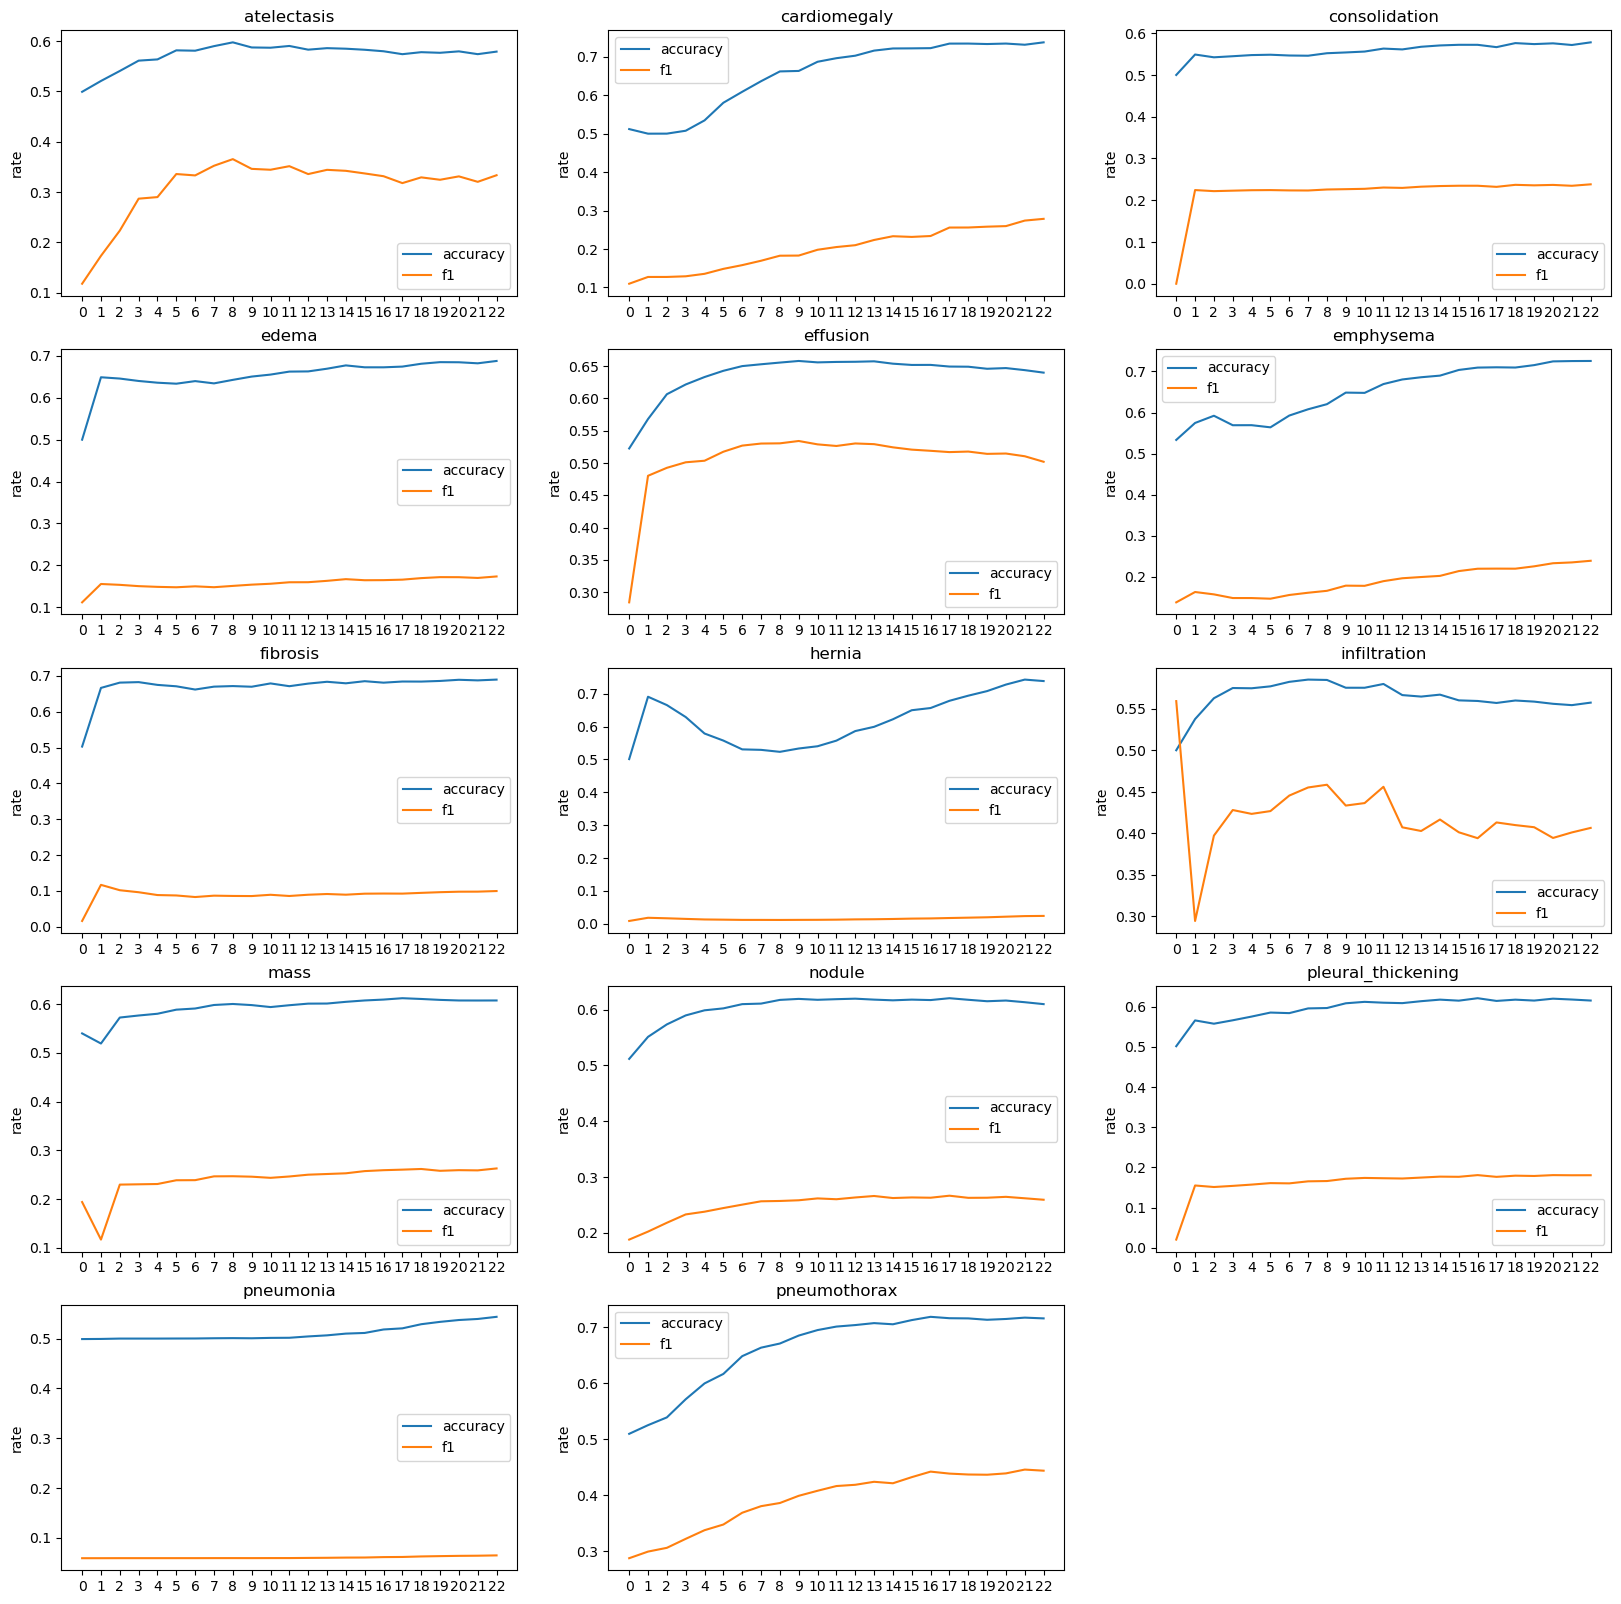

In [131]:
# from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
for i in range(14):
    plt.subplot(5, 3, i + 1)
    plt.plot(range(len(class_accs) + 1), np.array([np.array(class_accuracies_pretrained), *class_accs])[:, i], label='accuracy')
    plt.plot(range(len(class_accs) + 1), np.array([np.array(f1_pretrained), *class_f1])[:, i], label='f1')
    plt.legend()
#     plt.plot(range(1, 11), np.array(class_accuracies_by_epochs)[:, i])
    plt.xticks(ticks=range(len(class_accs) + 1))
    plt.title(labels[i])
#     plt.xlabel('epoch')
    plt.ylabel('rate')

Text(0, 0.5, 'rate')

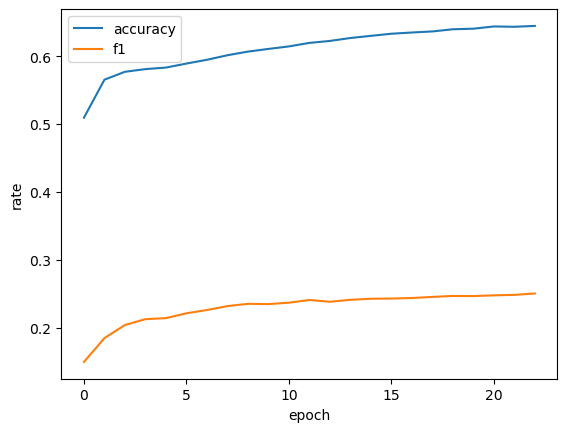

In [61]:
plt.plot(range(len(mean_accs) + 1),
         [np.mean(class_accuracies_pretrained), *mean_accs], label='accuracy')
plt.plot(range(len(mean_accs) + 1),
         [np.mean(f1_pretrained), *mean_f1], label='f1')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('rate')